<a href="https://colab.research.google.com/github/sharmaanj200/Clickbait-Detection-Project/blob/main/ConvolutionNeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import seaborn as sns
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image

In [4]:
# Specify the path to the JSON file
truth_json_file_path = '/content/sample_data/truth.jsonl'

# Load the JSON Lines file into a DataFrame
truth_df = pd.read_json(truth_json_file_path, lines=True)

# Specify the path to the JSON Lines file
instances_jsonl_file_path = '/content/sample_data/instances.jsonl'

# Load the JSON Lines file into a DataFrame
instance_df = pd.read_json(instances_jsonl_file_path, lines=True)

In [5]:
def format_post_media(value):
    path = ""
    for ch in value:
      if ch != '[' and ch != ']':
        path += ch;
    return path

# Applying the function to the entire column
instance_df['postMedia'] = instance_df['postMedia'].apply(format_post_media)


media_folder_path = '/content/drive/MyDrive/'
def append_drive_link(image_path):
    if pd.isnull(image_path):
        return image_path
    else:
        return media_folder_path + image_path

# Apply the function to the column 'postMedia'
instance_df['postMedia'] = instance_df['postMedia'].apply(append_drive_link)

In [6]:
# merge by id
merged_df = pd.merge(instance_df, truth_df, on='id', how='inner')
merged_df.drop(columns=['id', 'postText', 'targetTitle', 'targetDescription', 'targetKeywords', 'targetParagraphs', 'targetCaptions', 'truthJudgments', 'truthMean', 'truthMedian', 'truthMode', 'postTimestamp'], inplace=True)

In [7]:
# Remove rows where 'postMedia' is exactly '/content/drive/MyDrive/' which indicates no image
merged_df = merged_df[merged_df['postMedia'] != '/content/drive/MyDrive/']

In [8]:
merged_df

,postMedia,truthClass
1,/content/drive/MyDrive/media/60929710909597286...,no-clickbait
4,/content/drive/MyDrive/media/60868878282145382...,clickbait
5,/content/drive/MyDrive/media/60955103898347520...,clickbait
6,/content/drive/MyDrive/media/60944740895571968...,no-clickbait
9,/content/drive/MyDrive/media/60904621455475507...,no-clickbait
...,...,...
2452,/content/drive/MyDrive/media/60804017380544512...,no-clickbait
2453,/content/drive/MyDrive/media/60938911284854784...,clickbait
2455,/content/drive/MyDrive/media/61012581511686553...,no-clickbait
2456,/content/drive/MyDrive/media/60833858749562880...,no-clickbait


In [9]:
# First, split the data into train and test sets
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

# Then, split the train set into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [10]:
import os

# Create directories for train, test, and validation data
train_dir = '/content/sample_data/train_dir'
test_dir = '/content/sample_data/test_dir'
valid_dir = '/content/sample_data/valid_dir'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

# Save train, test, and validation DataFrames as CSV files
train_df.to_csv(os.path.join(train_dir, 'train_data.csv'), index=False)
test_df.to_csv(os.path.join(test_dir, 'test_data.csv'), index=False)
val_df.to_csv(os.path.join(valid_dir, 'valid_data.csv'), index=False)

In [11]:
#CNN Based Model in Keras

model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape=(224,224,3)))

model.add(Conv2D (64, (3,3), activation = 'relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Conv2D (64, (3,3), activation = 'relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Conv2D (128, (3,3), activation= 'relu'))

model.add(MaxPooling2D (pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense (64, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense (1, activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                   

In [13]:
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
)

test_dataset = image.ImageDataGenerator(rescale = 1./255)

In [14]:
from keras.preprocessing.image import ImageDataGenerator

# Read the CSV file into a DataFrame
df = pd.read_csv('/content/sample_data/train_dir/train_data.csv')

# Define train generator using flow_from_dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory='/content/sample_data/train_dir',
    x_col='postMedia',
    y_col='truthClass',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 1168 validated image filenames belonging to 2 classes.


In [15]:
train_generator.class_indices

{'clickbait': 0, 'no-clickbait': 1}

In [16]:
from keras.preprocessing.image import ImageDataGenerator

# Read the CSV file into a DataFrame
df = pd.read_csv('/content/sample_data/valid_dir/valid_data.csv')

# Define train generator using flow_from_dataframe
validation_generator = test_dataset.flow_from_dataframe(
    dataframe=df,
    directory='/content/sample_data/valid_dir',
    x_col='postMedia',
    y_col='truthClass',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 130 validated image filenames belonging to 2 classes.


In [17]:
# Read the CSV file into a DataFrame for testing
test_df = pd.read_csv('/content/sample_data/test_dir/test_data.csv')

# Define test generator using flow_from_dataframe for testing
test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_df,
    directory='/content/sample_data/test_dir',
    x_col='postMedia',
    y_col='truthClass',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 325 validated image filenames belonging to 2 classes.


In [19]:
# Fit the model using the calculated steps_per_epoch and validation_steps
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=5
)

<ipython-input-19-9e1825d1a1a0>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/10
10/10 [==============================] - 122s 12s/step - loss: 0.8835 - accuracy: 0.6187 - val_loss: 0.6519 - val_accuracy: 0.6538
Epoch 2/10
10/10 [==============================] - 107s 11s/step - loss: 0.6544 - accuracy: 0.7125 - val_loss: 0.6541 - val_accuracy: 0.6538
Epoch 3/10
10/10 [==============================] - 106s 11s/step - loss: 0.6508 - accuracy: 0.6625 - val_loss: 0.6590 - val_accuracy: 0.6538
Epoch 4/10
10/10 [==============================] - 106s 11s/step - loss: 0.6430 - accuracy: 0.7031 - val_loss: 0.6450 - val_accuracy: 0.6538
Epoch 5/10
10/10 [==============================] - 107s 11s/step - loss: 0.6474 - accuracy: 0.6687 - val_loss: 0.6391 - val_accuracy: 0.6538
Epoch 6/10
10/10 [==============================] - 116s 12s/step - loss: 0.6334 - accuracy: 0.6844 - val_loss: 0.6423 - val_accuracy: 0.6538
Epoch 7/10
10/10 [==============================] - 106s 11s/step - loss: 0.6424 - accuracy: 0.6687 - val_loss: 0.6423 - val_accuracy: 0.6538
Epoch 

In [20]:
model.evaluate_generator(train_generator)

<ipython-input-20-e4ade065aa26>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(train_generator)


[0.6119183301925659, 0.6977739930152893]

In [21]:
model.evaluate_generator(validation_generator)

<ipython-input-21-8951cfd684a1>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(validation_generator)


[0.6414257884025574, 0.6538461446762085]

In [22]:
model.evaluate_generator(test_generator)

<ipython-input-22-faa0e9406f88>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[0.5767606496810913, 0.744615375995636]

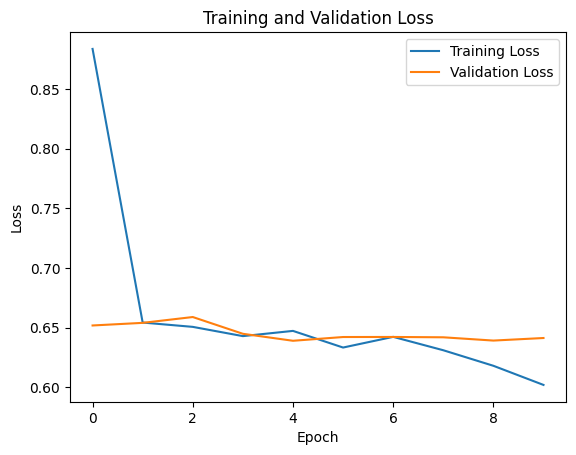

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

# Plot Training and Validation Loss
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

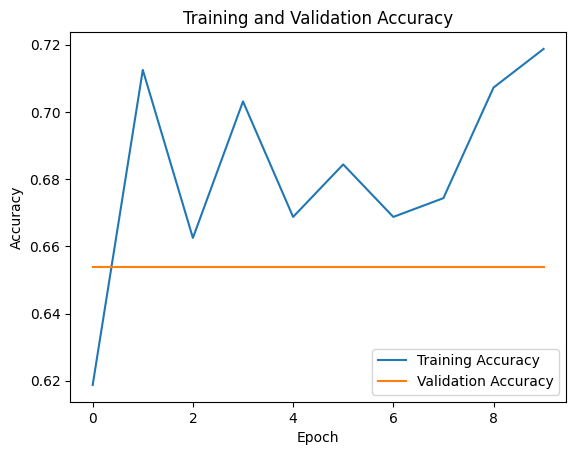

In [24]:
# Plot Training and Validation Accuracy
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [26]:
# Generate Confusion Matrix
test_predictions = model.predict_generator(test_generator).flatten()
test_predictions = (test_predictions > 0.5).astype(int)  # Convert probabilities to binary predictions
test_true_labels = test_generator.classes
conf_matrix = confusion_matrix(test_true_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

<ipython-input-26-d54d5b1b5ecc>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predictions = model.predict_generator(test_generator).flatten()


Confusion Matrix:
[[  0  83]
 [  0 242]]


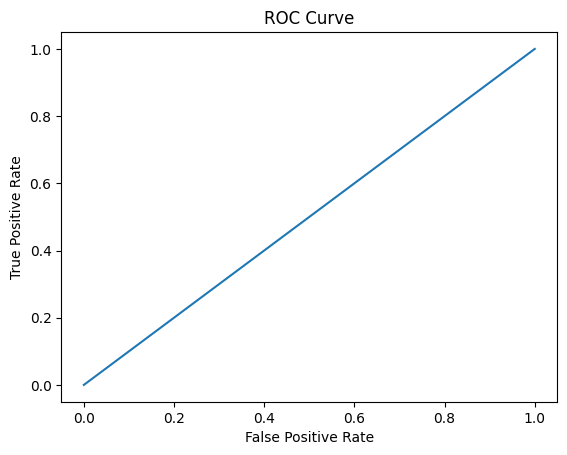

In [27]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(test_true_labels, test_predictions)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

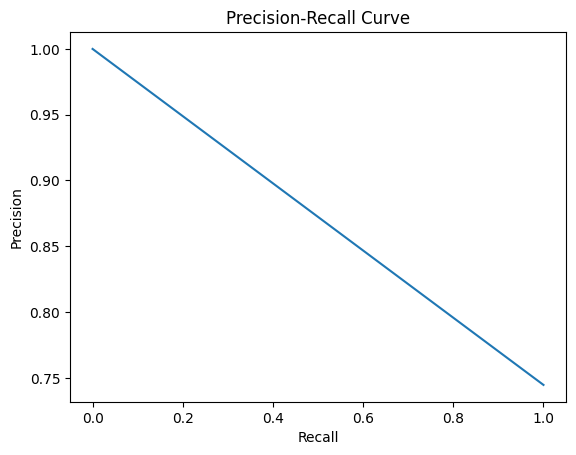

In [28]:
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_true_labels, test_predictions)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()